In [1]:
import random
import os
import pretty_midi
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# torch stuff
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset

# we use GPU if available, otherwise CPU
device_to_use = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device_to_use)
print(f"Using {device_to_use} device")


Using cuda:0 device


In [2]:
DATA_PATH = "../_data"

def get_samples(style="J", train=True, n=100, random=False):
    """Return the preprocessed samples

    Parameters
    ----------
    style : str, optional
        Style of the music, one of {"J", "C"} (for "Jazz" and "Classic"), by default "J"
    train : bool, optional
        Whether to choose the train or validation set, by default True
    n : int, optional
        Number of samples which will be returned, by default 100
    random : bool, optional
        Whether to randomize the samples or not, by default False

    Returns
    -------
    List (of Numpy arrays)
        List of samples
    """
    if style == "J":
        folder = "JC_J"
        prefix = "jazz"
    elif style == "C":
        folder = "JC_C"
        prefix = "classic"
    else:
        raise Exception("'style' must be one of {'J', 'C'}")

    train_or_valid = "train" if train else "test"

    nb_samples = sum(
        1
        for item in os.listdir(f"{DATA_PATH}/{folder}/{train_or_valid}")
        if os.path.isfile(os.path.join(f"{DATA_PATH}/{folder}/{train_or_valid}", item))
    )
    numbers = list(range(1, nb_samples))
    if random:
        np.random.shuffle(numbers)
    numbers = numbers[:n]

    samples = []
    for number in numbers:
        if os.path.isfile(f"{DATA_PATH}/{folder}/{train_or_valid}/{prefix}_piano_{train_or_valid}_{number}.npy"):
            sample = np.load(
                f"{DATA_PATH}/{folder}/{train_or_valid}/{prefix}_piano_{train_or_valid}_{number}.npy"
            )
            # samples.append(sample.astype(int).reshape((64 * 84, 1)))
            samples.append(sample.astype(int).reshape((1, 64 * 84)))

    # return np.column_stack(samples)
    return np.vstack(samples)

In [3]:
# d = get_samples()
# d.shape

In [4]:
def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn(size, batch_size))
    return n

In [6]:
latent_dim = 500

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        n_features = latent_dim
        n_out = 64 * 84
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        n_features = 64 * 84
        n_out = 1

        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [8]:
n = 2000
batch_size = 32
data = get_samples(n=n)
dataset = TensorDataset(torch.Tensor(data).type(torch.float), torch.Tensor(np.ones((data.shape[0], 1))).type(torch.int64))
loader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=batch_size)

Discriminator data distribution (batch 0)


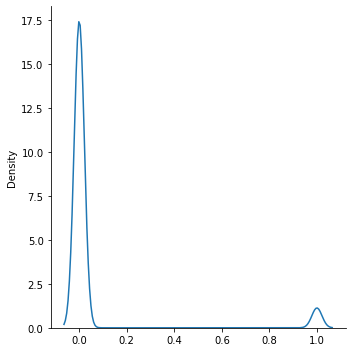

Note played simultaneously (in avg) for real data : 5.09814453125
Epoch 0: D (0.7264 real_err, 0.2770 fake_err) G (1.4797 err) 
Generated data: 
Min value: 0.44470447301864624 / Max value: 0.5494258999824524


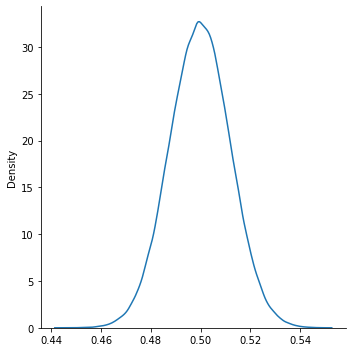

Note played simultaneously (in avg) for generated data : 41.97607421875
Epoch 20: D (0.6089 real_err, 0.5985 fake_err) G (0.8763 err) 
Generated data: 
Min value: 6.181031494634226e-05 / Max value: 0.993282675743103


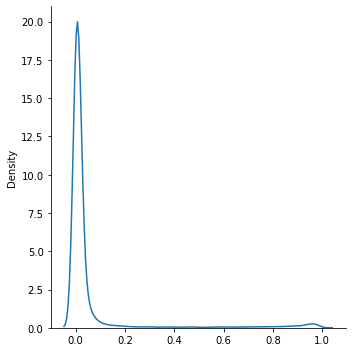

Note played simultaneously (in avg) for generated data : 4.618417263031006
Epoch 40: D (0.7353 real_err, 0.6451 fake_err) G (0.9052 err) 
Generated data: 
Min value: 7.05350685166195e-05 / Max value: 0.9939641356468201


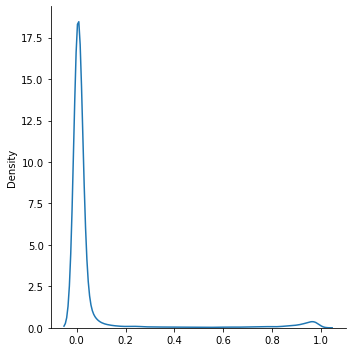

Note played simultaneously (in avg) for generated data : 5.063694953918457
Epoch 60: D (0.2861 real_err, 0.3285 fake_err) G (1.4760 err) 
Generated data: 
Min value: 0.00010943186498479918 / Max value: 0.9966668486595154


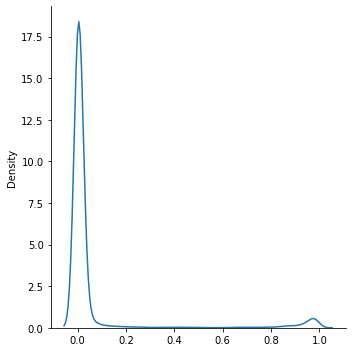

Note played simultaneously (in avg) for generated data : 5.096202850341797
Epoch 80: D (0.4235 real_err, 0.1590 fake_err) G (2.1455 err) 
Generated data: 
Min value: 5.193343895371072e-05 / Max value: 0.9997820258140564


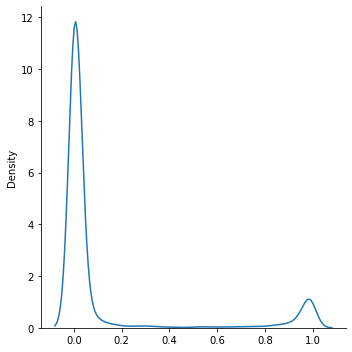

Note played simultaneously (in avg) for generated data : 10.276817321777344
Epoch 100: D (0.6224 real_err, 0.0613 fake_err) G (2.8089 err) 
Generated data: 
Min value: 0.0003507985966280103 / Max value: 0.9985462427139282


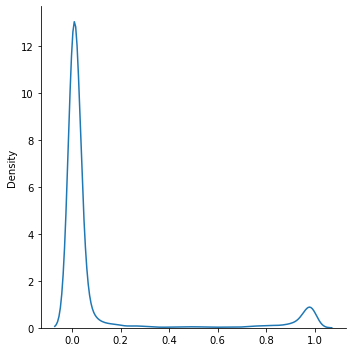

Note played simultaneously (in avg) for generated data : 8.820144653320312
Epoch 120: D (0.0174 real_err, 0.0224 fake_err) G (3.8725 err) 
Generated data: 
Min value: 2.673082024826079e-12 / Max value: 0.9999939203262329


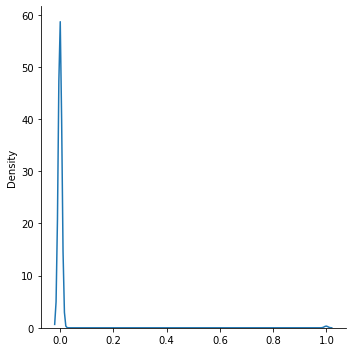

Note played simultaneously (in avg) for generated data : 0.4821813404560089
Epoch 140: D (0.0158 real_err, 0.0009 fake_err) G (7.4016 err) 
Generated data: 
Min value: 3.322587538434618e-09 / Max value: 1.0


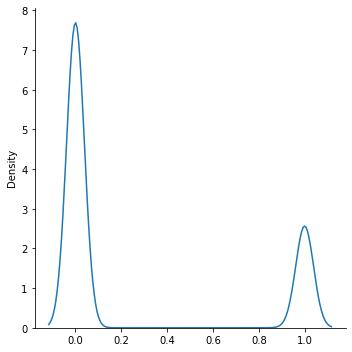

Note played simultaneously (in avg) for generated data : 21.046218872070312
Epoch 160: D (0.0056 real_err, 0.0011 fake_err) G (7.9640 err) 
Generated data: 
Min value: 2.075481191062517e-17 / Max value: 1.0


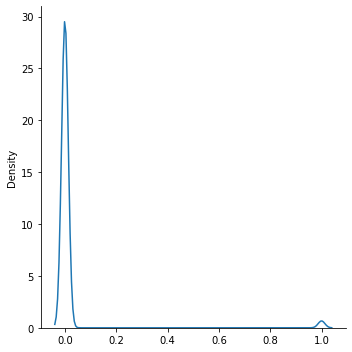

Note played simultaneously (in avg) for generated data : 1.8438770771026611
Epoch 180: D (0.0002 real_err, 0.0021 fake_err) G (6.8056 err) 
Generated data: 
Min value: 1.9798251564872416e-18 / Max value: 0.9999997615814209


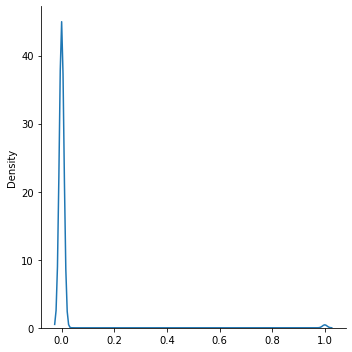

Note played simultaneously (in avg) for generated data : 0.8129298686981201
Epoch 200: D (0.0022 real_err, 0.0017 fake_err) G (6.2102 err) 
Generated data: 
Min value: 3.7747754460688815e-18 / Max value: 0.9999992847442627


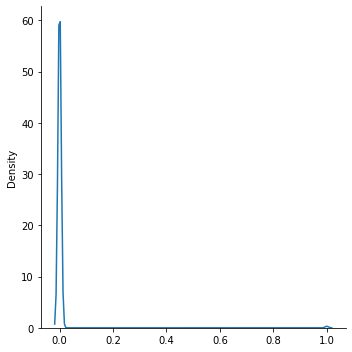

Note played simultaneously (in avg) for generated data : 0.39086899161338806


KeyboardInterrupt: 

In [9]:
n_epochs = 500

G = Generator().to(device)
D = Discriminator().to(device)

loss = nn.BCELoss()
d_optimizer = optim.SGD(D.parameters(), lr=1e-3, momentum=0.8)
g_optimizer = optim.SGD(G.parameters(), lr=1e-3, momentum=0.8)

fake_data_list = []

def extract(v):
    return v.data.storage().tolist()
epochs = []
d_fake_errs = []
d_reak_errs = []
g_errs = []

# d_avg_notes = 0

for epoch in range(n_epochs):
    # for _ in range(20):  # train D for 20 steps
    for batch_idx, sample in enumerate(loader):


        D.zero_grad()  # could be d_optimizer.zero_grad() since the optimizer is specific to the model

        inputs, labels = sample
        N = len(inputs)
        # print(N)
        inputs_real_data, labels_real_data = inputs.to(device), labels.to(device)

        if epoch == 0 and batch_idx == 0:
            print("Discriminator data distribution (batch 0)")
            sns.displot(inputs_real_data.cpu().detach().numpy().flatten(), kind="kde")
            plt.show()
            print(f"Note played simultaneously (in avg) for real data : {inputs_real_data.cpu().detach().numpy().flatten().sum() / ( N * 64):.2f}")

        d_real_decision = D(inputs_real_data)
        d_real_error = loss(
            d_real_decision, Variable(torch.ones([N, 1])).to(device)
        )  # ones = true
        d_real_error.backward()  # compute/store gradients, but don't change params

        # train D on fake data
        d_gen_seed = Variable(torch.FloatTensor(torch.randn(N, latent_dim))).to(
            device
        )
        d_fake_data = G(d_gen_seed).detach()  # detach to avoid training G on these labels
        d_fake_decision = D(d_fake_data)
        d_fake_error = loss(
            d_fake_decision, Variable(torch.zeros([N, 1]).to(device))
        )  # zeros = fake
        d_fake_error.backward()
        d_optimizer.step()  # Only optimizes D's parameters; changes based on stored gradients from backward()

        dre, dfe = extract(d_real_error)[0], extract(d_fake_error)[0]

        for _ in range(10):
            G.zero_grad()

            g_gen_seed = Variable(torch.FloatTensor(torch.randn(N, latent_dim))).to(
                device
            )
            g_fake_data = G(g_gen_seed)
            dg_fake_decision = D(g_fake_data)
            g_error = loss(
                dg_fake_decision, Variable(torch.ones([N, 1]).to(device))
            )  # Train G to pretend it's genuine

            g_error.backward()
            g_optimizer.step()  # Only optimizes G's parameters

            ge = extract(g_error)[0]

    epochs.append(epoch)
    d_fake_errs.append(dfe)
    d_real_errs.append(dre)
    g_errs.append(ge)

    if epoch % 20 == 0:
        print(
            "Epoch %s: D (%1.4f real_err, %1.4f fake_err) G (%1.4f err) "
            % (epoch, dre, dfe, ge)
        )
        numpy_fake_data = g_fake_data.cpu().detach().numpy()
        print("Generated data:", f"\nMin value: {numpy_fake_data.min()} / Max value: {numpy_fake_data.max()}")
        sns.displot(numpy_fake_data.flatten(), kind="kde")
        plt.show()
        print(f"Note played simultaneously (in avg) for generated data : {numpy_fake_data.sum() / (N * 64):.2f}")
        fake_data_list.append((epoch, numpy_fake_data[0, :]))

print(
    "Epoch %s: D (%1.4f real_err, %1.4f fake_err) G (%1.4f err) "
    % (epoch, dre, dfe, ge)
)

In [49]:
g_fake_data[0]

tensor([0.0025, 0.0019, 0.0219,  ..., 0.0030, 0.0020, 0.0018], device='cuda:0',
       grad_fn=<SelectBackward>)

In [80]:
numpy_fake_data[0, :]

array([1.8221685e-05, 1.4852511e-05, 4.2209867e-04, ..., 2.1437711e-05,
       8.2809256e-06, 8.6161435e-06], dtype=float32)

In [56]:
data.shape[0]

990

In [11]:
def raw_to_midi(array, name, precision=1e-2):
    pm = pretty_midi.PrettyMIDI()
    # Create an Instrument instance
    program = pretty_midi.instrument_name_to_program('Cello')
    piano = pretty_midi.Instrument(program=program)
    # array = tensor.cpu().detach().numpy()
    # def _round(x):
    #     if x < precision:
    #         return 0
    #     elif x > 1 - precision:
    #         return 1
    #     return x
    array = np.array(list(map(lambda x: 0 if x < precision else 1, array)))
    array = array.reshape((64, 84))
    for time_idx in range(64):
        for pitch_idx in range(84):
            if array[time_idx, pitch_idx] == 1:
                note = pretty_midi.Note(
                velocity=100, pitch=25 + pitch_idx, start=1 / 16 * time_idx, end=1 / 16 * (time_idx + 1))
                # Add it to our instrument
                piano.notes.append(note)
    pm.instruments.append(piano)
    # Write out the MIDI data
    pm.write(f'midi_results/{name}.mid')
    
        



In [53]:
a = g_fake_data[0].cpu().detach().numpy()
raw_to_midi(a, "test", precision=1e-1)

In [58]:
a

array([0.0025025 , 0.00185667, 0.02190318, ..., 0.00295474, 0.00201577,
       0.00181699], dtype=float32)

In [59]:
raw_to_midi(data[0], "normal", precision=1e-1)

In [88]:
idx = [t[0] for t in fake_data_list].index(100)
fake_data_list[idx][1]

array([0.00141782, 0.00114806, 0.00230734, ..., 0.00062539, 0.0010109 ,
       0.00193889], dtype=float32)

In [12]:
for tuple in fake_data_list:
    raw_to_midi(tuple[1], f"nice_10steps_{tuple[0]}")

In [12]:
raw_to_midi(fake_data_list[-1][1], f"5000")

In [9]:
fake_data_list

[(0,
  array([0.4944722 , 0.48824844, 0.5040509 , ..., 0.4672277 , 0.50416726,
         0.50914097], dtype=float32)),
 (20,
  array([4.2990767e-04, 3.0212823e-04, 1.6526238e-03, ..., 7.9703328e-05,
         1.1255940e-03, 8.9708244e-04], dtype=float32)),
 (40,
  array([0.00567092, 0.00258316, 0.01168862, ..., 0.00304571, 0.00492434,
         0.00556258], dtype=float32)),
 (60,
  array([0.00121755, 0.00027669, 0.01548108, ..., 0.00043324, 0.00051334,
         0.00030826], dtype=float32)),
 (80,
  array([1.4379176e-03, 4.3764905e-04, 4.8852971e-01, ..., 6.6985749e-04,
         4.7460065e-04, 3.3473939e-04], dtype=float32)),
 (100,
  array([0.00073991, 0.0003188 , 0.00693077, ..., 0.0008195 , 0.00040314,
         0.00026975], dtype=float32)),
 (120,
  array([2.4394337e-03, 6.9980620e-04, 9.4728804e-01, ..., 4.0026554e-03,
         1.0089302e-03, 5.6759396e-04], dtype=float32)),
 (140,
  array([0.00043589, 0.00013761, 0.00021011, ..., 0.00055069, 0.0001505 ,
         0.00015804], dtype=flo

In [75]:
np.median(g_fake_data[0].cpu().detach().numpy())

0.008360177

In [89]:
print(f"Note played simultaneously (in avg) for real data : {data[0].sum() / 64}")
print(f"Note played simultaneously (in avg) for fake data : {g_fake_data[0].cpu().detach().numpy().sum() / 64}")
print(f"Note played simultaneously (in avg) for fake data : {fake_data_list[idx][1].sum() / 64}")

Note played simultaneously (in avg) for real data : 4.9375
Note played simultaneously (in avg) for fake data : 1.475616455078125
Note played simultaneously (in avg) for fake data : 4.571640968322754
